# Base model

### Data load & Split

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(raw_train)
print(raw_validation)
print(raw_test)
type(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


tensorflow.python.data.ops.dataset_ops.PrefetchDataset

### Data check

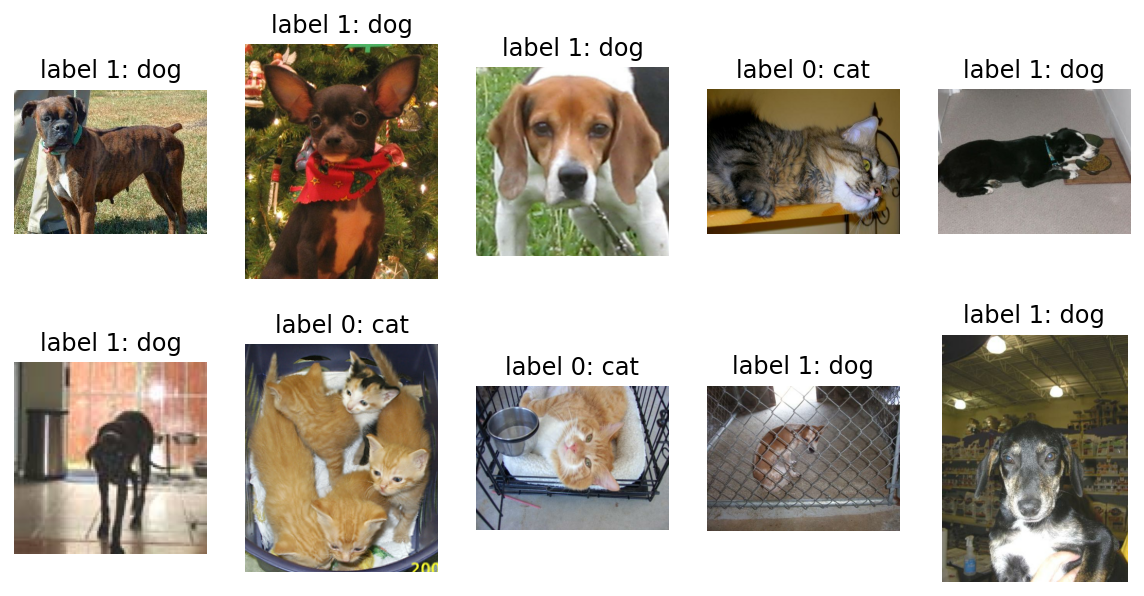

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### Image resize

In [4]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [5]:
# format_example로 정규화 
#  format_example이 인자가 없어도되는 이유는 
# raw_train에서 map이 callback으로 인자를 가져온다
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

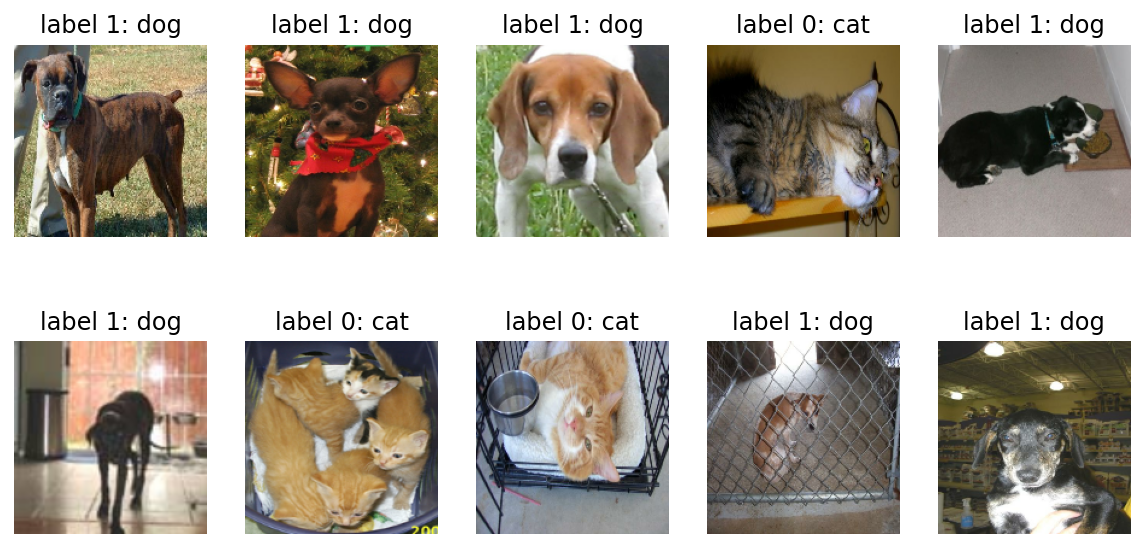

In [6]:
## regularize & resize 된 데이터 재확인 

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### Making model structure

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

### Setting batches , learning rate

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [11]:
# train_batches는 모델이 끊임없이 학습할 수 있도록
# 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [12]:
# 해당 데이터셋 구조 타입은 take로 꺼내와야함 

for image,label in train_batches.take(1):
    print(f'이미지 배치 shape : {image.shape}\n label shape :{label.shape}')

# [데이터의 개수,height , width , channel ]      

이미지 배치 shape : (32, 160, 160, 3)
 label shape :(32,)


In [13]:
train_batches.take(1)

<TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>

### Check validation accuracy

In [14]:
# 모델 학습없이 단순 validation 20개에 대한 accuracy
# 이거 다음 셀에 model.fit하고 비교해볼거임 
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps )

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 0s 15ms/step - loss: 0.7096 - accuracy: 0.4703
initial loss: 0.71
initial accuracy: 0.47


### Training model

In [15]:
# 에폭 10으로 학습시켜 보기 
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 33s 57ms/step - loss: 0.5923 - accuracy: 0.6762 - val_loss: 0.5683 - val_accuracy: 0.7038
Epoch 2/10
582/582 [==============================] - 19s 33ms/step - loss: 0.4997 - accuracy: 0.7551 - val_loss: 0.5210 - val_accuracy: 0.7541
Epoch 3/10
582/582 [==============================] - 19s 33ms/step - loss: 0.4410 - accuracy: 0.7958 - val_loss: 0.4672 - val_accuracy: 0.7885
Epoch 4/10
582/582 [==============================] - 19s 33ms/step - loss: 0.3916 - accuracy: 0.8234 - val_loss: 0.4741 - val_accuracy: 0.7794
Epoch 5/10
582/582 [==============================] - 19s 33ms/step - loss: 0.3446 - accuracy: 0.8495 - val_loss: 0.4640 - val_accuracy: 0.7902
Epoch 6/10
582/582 [==============================] - 19s 33ms/step - loss: 0.2969 - accuracy: 0.8773 - val_loss: 0.4617 - val_accuracy: 0.8018
Epoch 7/10
582/582 [==============================] - 19s 33ms/step - loss: 0.2553 - accuracy: 0.8967 - val_loss: 0.5461 - val_accuracy:

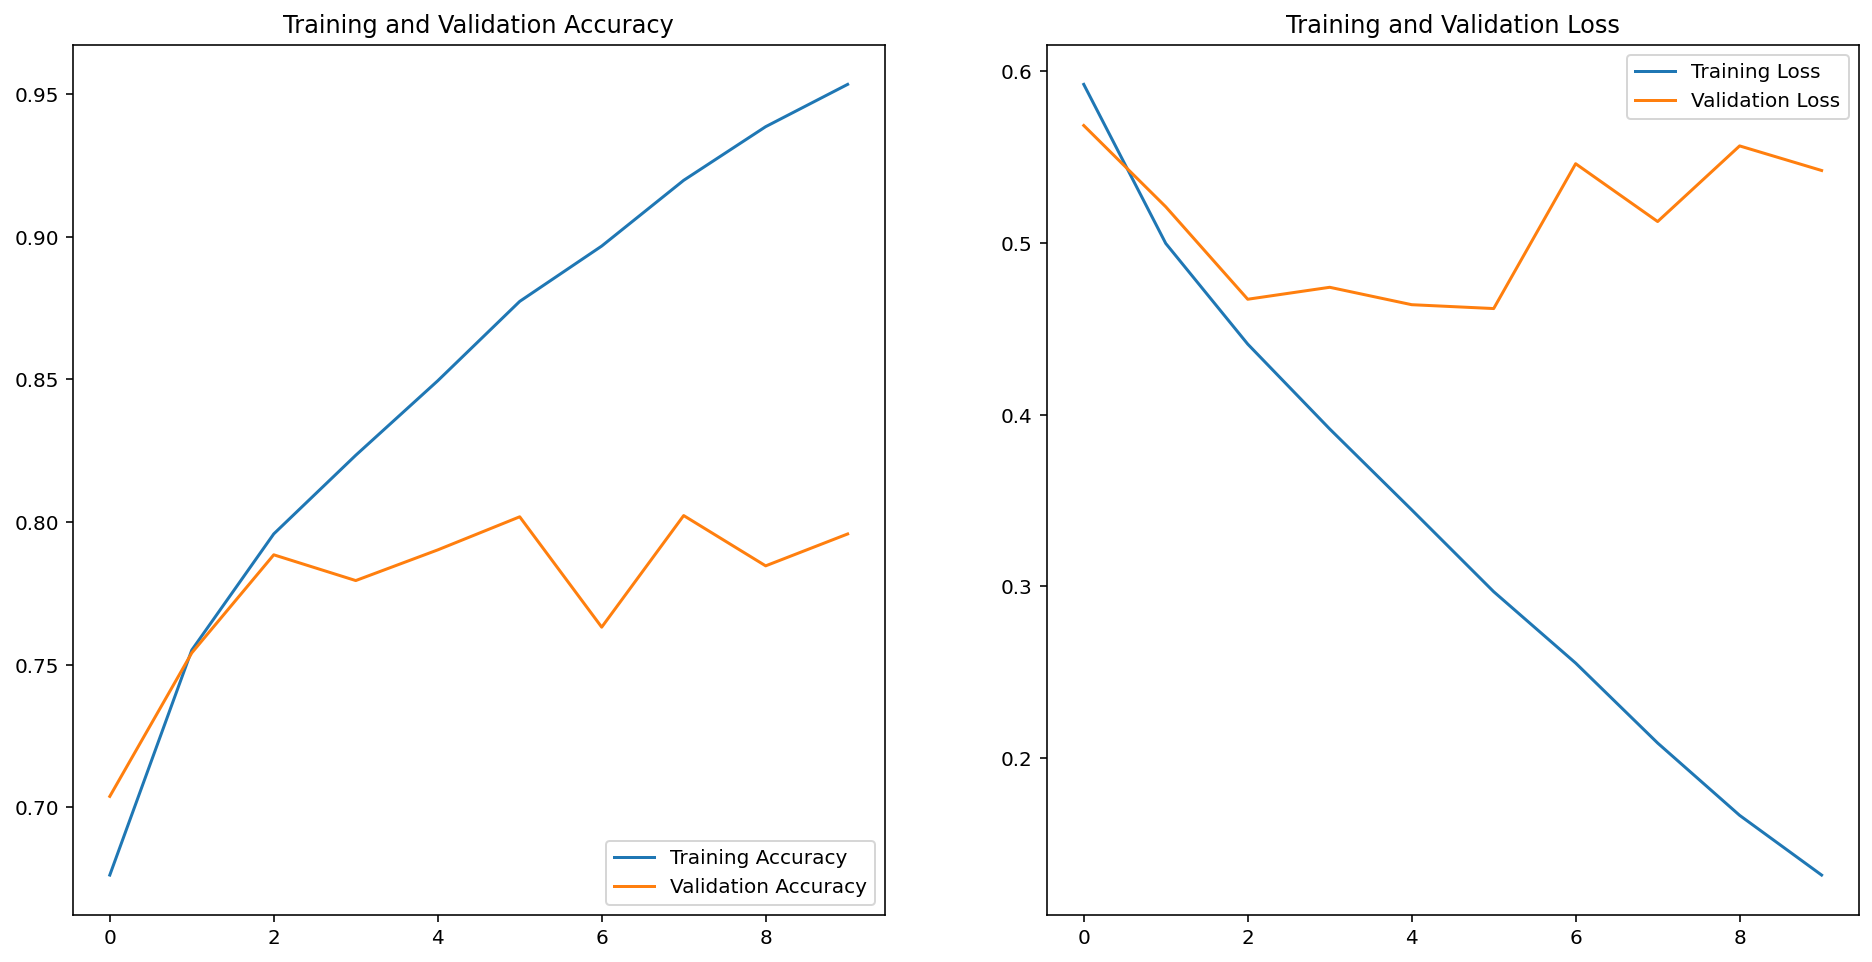

In [17]:
# 학습 곡선 시각화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Checking model predict with visualiztion

In [26]:
# model의 predict값 확인하고 싶을 때
# 이거는 take로 1(32개)개만 가져와서 확인
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9928254e-01, 7.1745861e-04],
       [8.9305055e-01, 1.0694941e-01],
       [5.4973173e-01, 4.5026830e-01],
       [9.9974936e-01, 2.5066239e-04],
       [8.3160973e-01, 1.6839026e-01],
       [8.5509211e-02, 9.1449082e-01],
       [8.7807350e-02, 9.1219258e-01],
       [3.1696007e-01, 6.8303996e-01],
       [1.6534625e-01, 8.3465374e-01],
       [6.0034412e-01, 3.9965594e-01],
       [8.9634091e-02, 9.1036594e-01],
       [9.9962306e-01, 3.7686608e-04],
       [9.9916077e-01, 8.3927915e-04],
       [5.0312787e-04, 9.9949682e-01],
       [9.9142379e-01, 8.5761789e-03],
       [9.9925047e-01, 7.4955856e-04],
       [8.6823022e-01, 1.3176976e-01],
       [4.7960780e-06, 9.9999523e-01],
       [3.9821592e-01, 6.0178411e-01],
       [9.8669553e-01, 1.3304455e-02],
       [8.8830626e-01, 1.1169376e-01],
       [9.1414803e-01, 8.5851982e-02],
       [9.9729162e-01, 2.7083650e-03],
       [9.8259002e-01, 1.7409965e-02],
       [9.2488295e-01, 7.5117044e-02],
       [9.0346895e-03, 9.

In [27]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

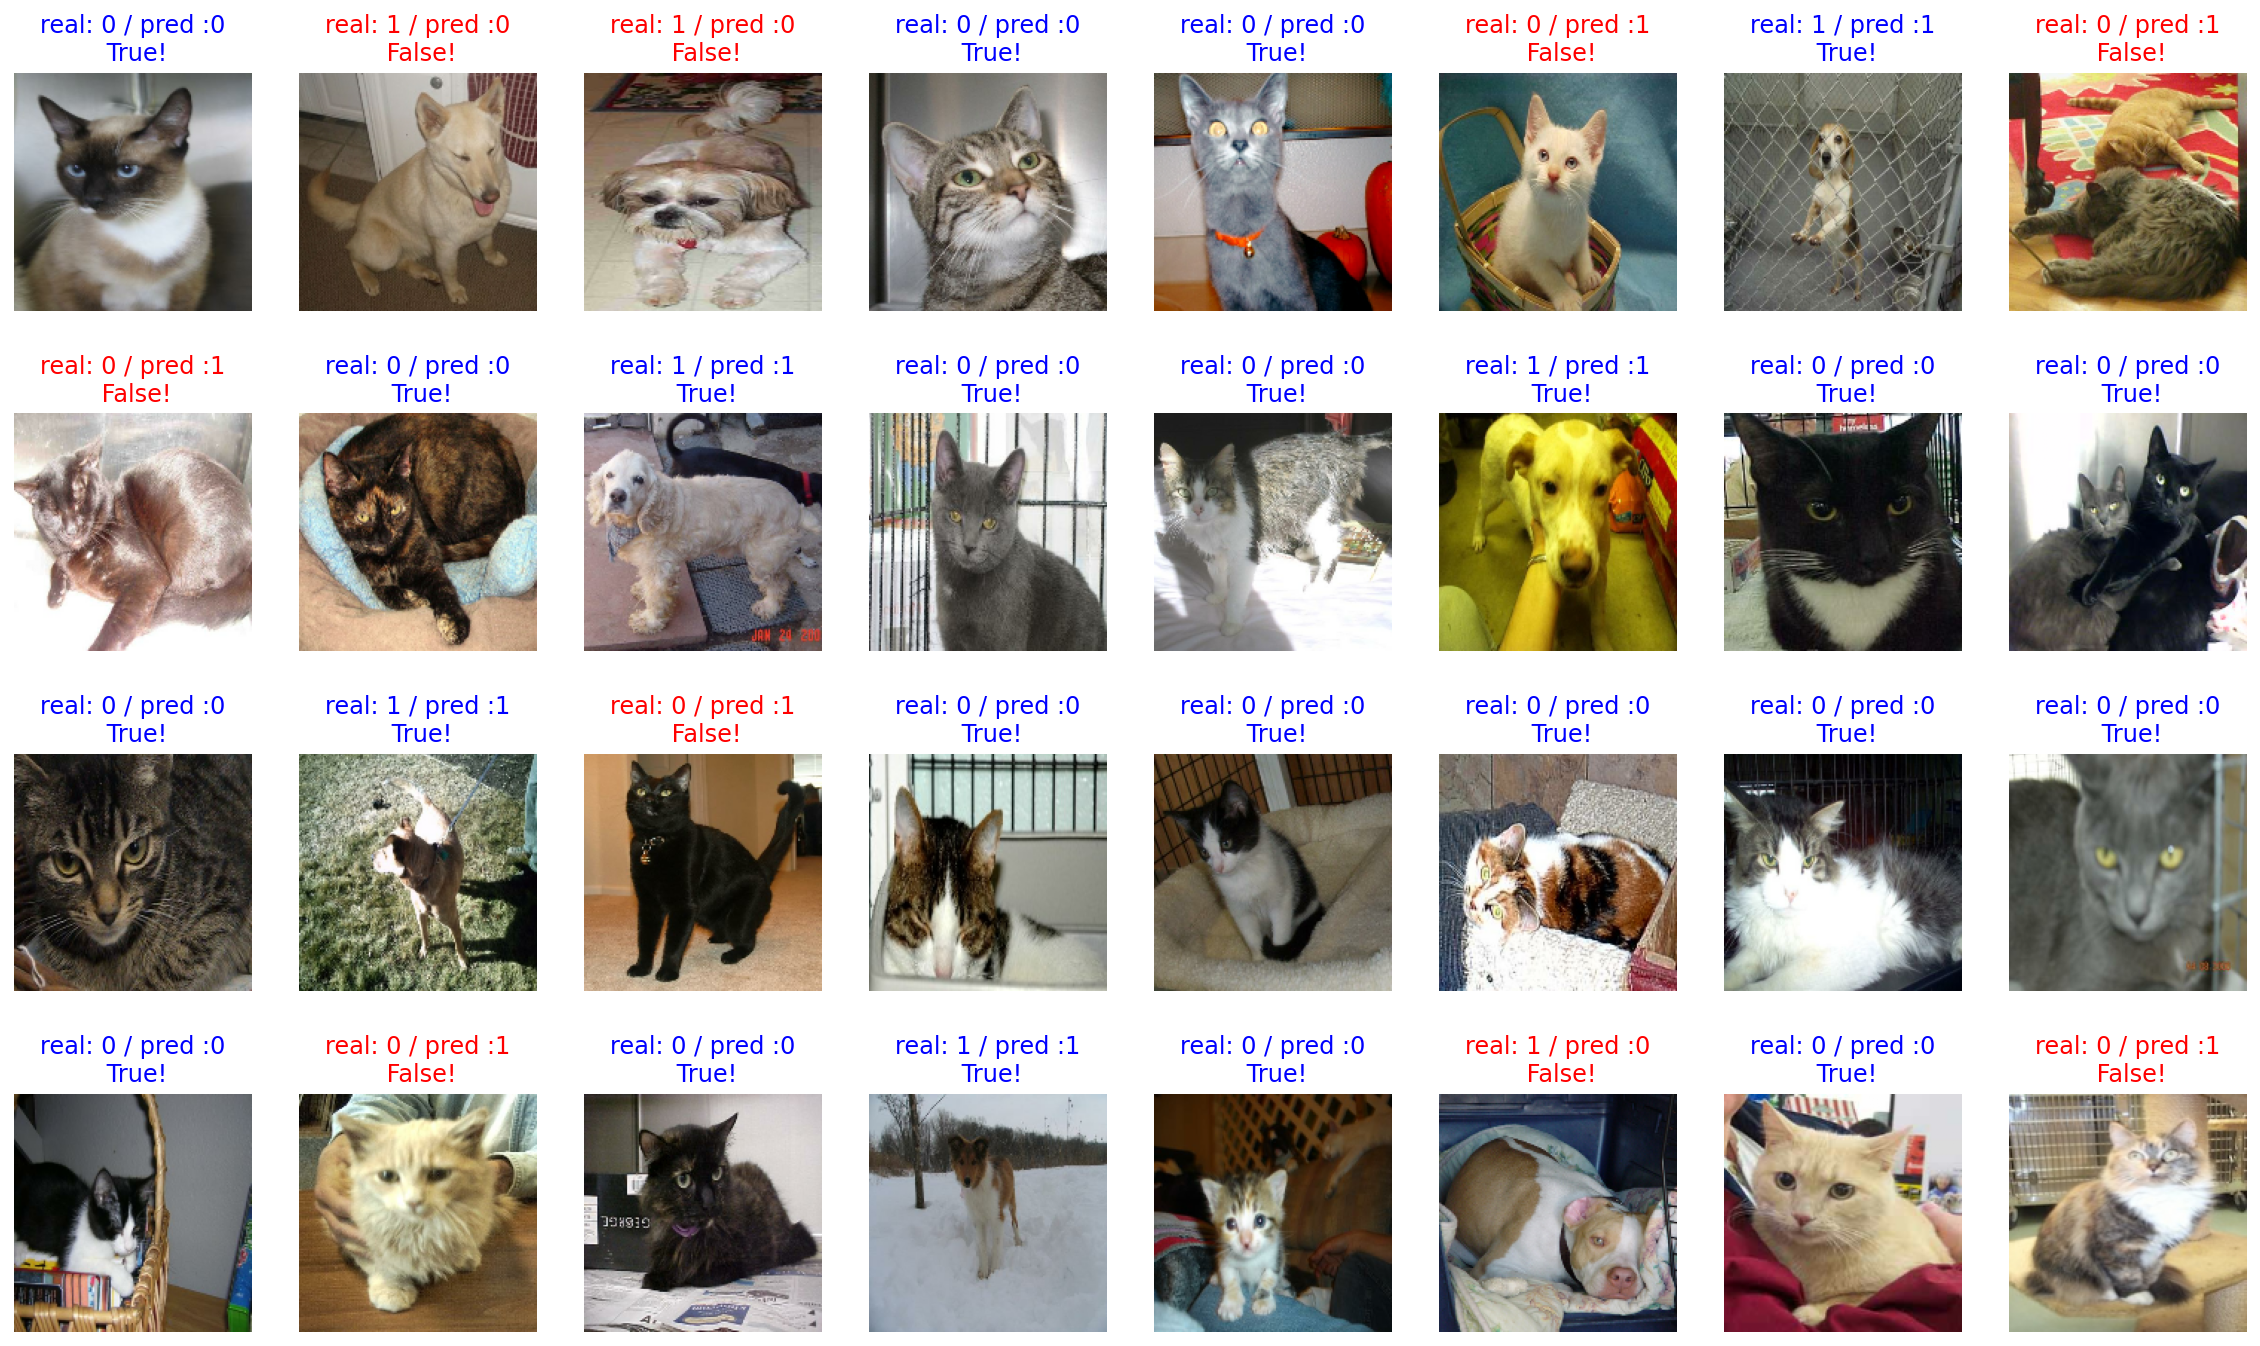

In [28]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [29]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    # [[YOUR CODE]]
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)    # 약 70% 내외

71.875


In [ ]:
dd


---

# Using Model VGG  

### Data load & Split

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

### Data check

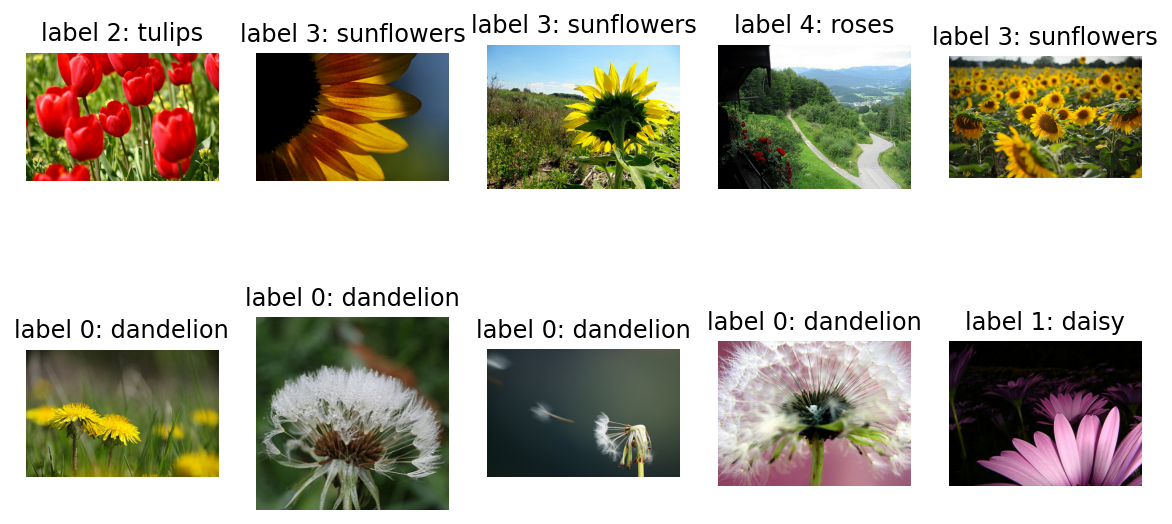

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### Image resize

In [5]:
IMG_SIZE = 170 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [6]:
# format_example로 정규화 
#  format_example이 인자가 없어도되는 이유는 
# raw_train에서 map이 callback으로 인자를 가져온다
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

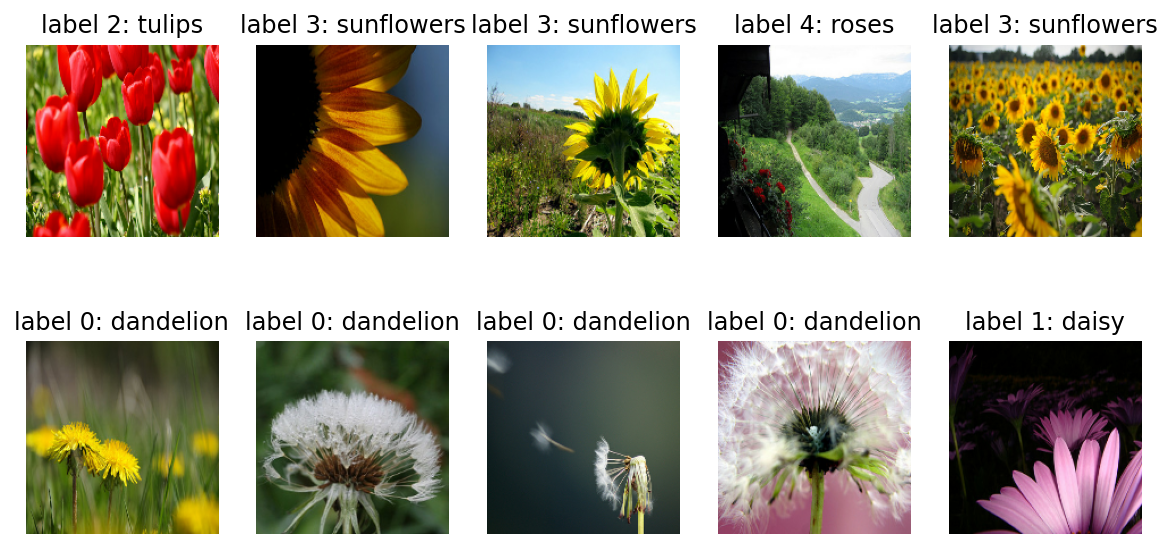

In [7]:
## regularize & resize 된 데이터 재확인 

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

기존에는 모델 sequntial 구성하고 compile 했다면   
이제는 VGG라는 모델을 불러올거니까  sequntial 구성은 필요없고(그냥 불러오면 되니까)
buffer_size나 batch size등 지정해줄 것들 한 후에   
모델 load 하고 컴파일 하고  classfier나 수정해줄 것들 수정해주면 된다.  
(여기의 예에서는 앞의 layer는 그대로 가져오는 vgg예제라 그렇다)

### Setting batches , learning rate

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [9]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

### Making model structure

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# pre-trained model VGG16 불러오기
vgg_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False, 
#output에 가까운 높은 레벨에 있는 3개의 FC 레이어는 제외하고 불러와야 하므로 include_top=False 옵션을 주었다.
                                         weights='imagenet')

include_top = False이므로 마지막 아웃풋단의 3개의 layer직접 추가하는 부분이 아래

In [11]:
# flatten대신 사용할 Gap layer
# flatten은 단순히 1렬의 정보로 만들어 각 픽셀의 정보의 단순나열인 반면
# GAP 는 채널당 전체 평균값으로 각각의 숫자가 채널의 정보를 담고있다
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#  dense층 2계층
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [12]:
# 모델 구성 

model = tf.keras.Sequential([
  vgg_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

vgg model +  우리가 추가한 layer들

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 14,979,909
Non-trainable params: 0
_________________________________________________________________


### Training model

In [14]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])


In [15]:
EPOCHS = 20   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 78s 847ms/step - loss: 0.7587 - accuracy: 0.7210 - val_loss: 0.6308 - val_accuracy: 0.7629
Epoch 2/20
92/92 [==============================] - 19s 210ms/step - loss: 0.4122 - accuracy: 0.8542 - val_loss: 0.4108 - val_accuracy: 0.8556
Epoch 3/20
92/92 [==============================] - 19s 210ms/step - loss: 0.3061 - accuracy: 0.8934 - val_loss: 0.3661 - val_accuracy: 0.8610
Epoch 4/20
92/92 [==============================] - 19s 211ms/step - loss: 0.2395 - accuracy: 0.9159 - val_loss: 0.3768 - val_accuracy: 0.8801
Epoch 5/20
92/92 [==============================] - 19s 211ms/step - loss: 0.1798 - accuracy: 0.9404 - val_loss: 0.3665 - val_accuracy: 0.8501
Epoch 6/20
92/92 [==============================] - 19s 211ms/step - loss: 0.1305 - accuracy: 0.9574 - val_loss: 0.3175 - val_accuracy: 0.9074
Epoch 7/20
92/92 [==============================] - 20s 212ms/step - loss: 0.0949 - accuracy: 0.9690 - val_loss: 0.4461 - val_accuracy: 0.8692

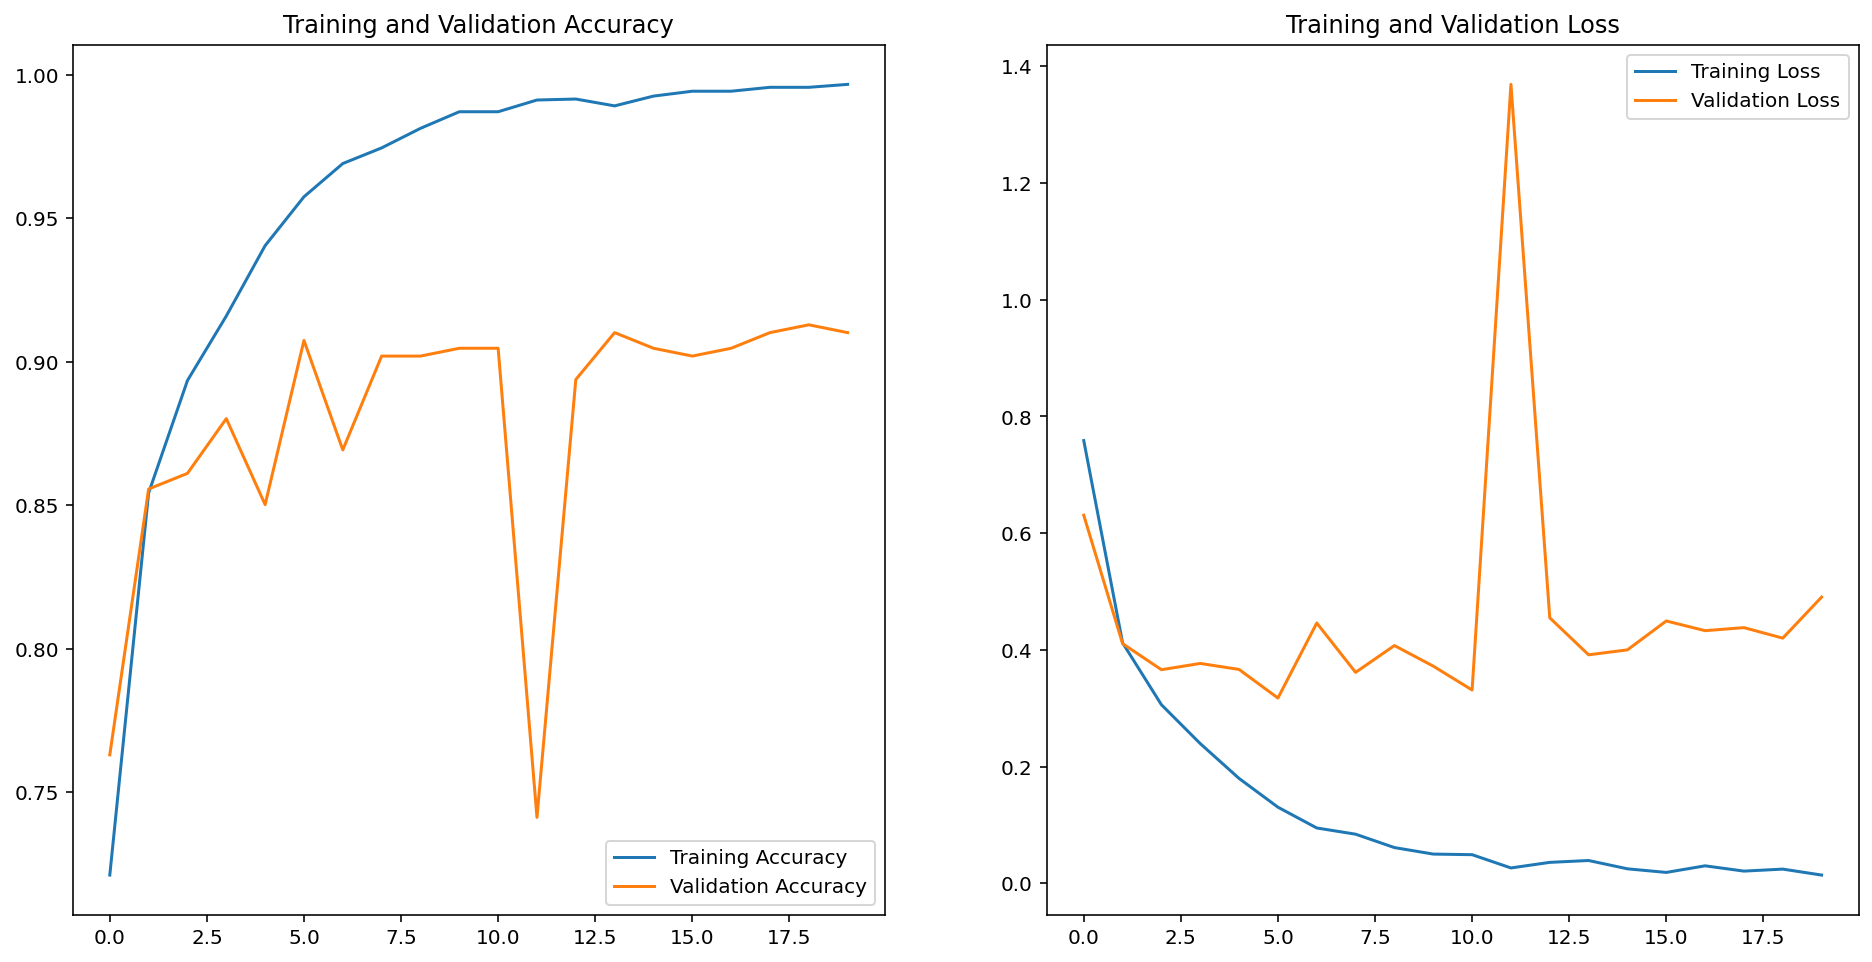

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### weights save

In [17]:
# 나중에 가중치 저장해야될 일 있을 경우에 이런식으로 저장 
import os

checkpoint_dir = os.getenv("HOME") + "/tf_flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [18]:
test_steps = 10
loss0, accuracy0 = model.evaluate(test_batches, steps = test_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 1s 62ms/step - loss: 0.3632 - accuracy: 0.9219
initial loss: 0.36
initial accuracy: 0.92
